# 青空文庫作品の著者推定：機械学習による文体分析

## 📚 研究概要

本研究では、青空文庫に掲載されている日本語文学作品の文体的特徴を解析し、機械学習を用いて著者を推定するシステムを構築します。

### 🎯 研究目的
文体特徴量（統計的特徴量13種類 + N-gram特徴量150種類）と複数の機械学習モデルを使用して、テキストの著者を高精度で分類することを目指します。

### 🔬 手法の特徴
1. **形態素解析による統計的特徴量**: 平均文長、品詞比率、語彙多様性など13種類
2. **文字N-gram特徴量**: TF-IDFによる文体パターン抽出（最大150次元）
3. **PCA次元削減**: N-gram特徴量を75次元に削減し、特徴量バランスを改善
4. **5種類のモデル比較**: Logistic Regression, Random Forest, SVM, Gradient Boosting, Neural Network
5. **データリーク対策**: 訓練/テスト分割を最優先し、全処理で徹底

### 📊 実験設計
- **評価方法**: 5-fold Cross Validation × 10回の反復実験
- **統計検定**: 一元配置分散分析（ANOVA）+ 多重比較検定（Tukey HSD）
- **データ分割**: 訓練80% / テスト20%（stratified sampling）


## 🔍 研究仮説

### 仮説1: モデル性能の順序予想
文体特徴は非線形な関係を持つと考えられるため、以下のモデル性能順序を予想：

**予想順位**: SVM > Random Forest > Gradient Boosting > Neural Network > Logistic Regression

**理由**:
- SVM (RBF kernel): 非線形境界を捉えられるため最高精度を期待
- Random Forest & Gradient Boosting: 特徴量間の相互作用を学習可能
- Neural Network: 複雑なパターン学習が可能だが、データ数が限られる場合は過学習のリスク
- Logistic Regression: 線形分離の限界により最も低精度と予想

### 仮説2: 重要な特徴量の予想
著者の文体を特徴づける要素として、以下が重要と予想：

1. **文末表現**: 丁寧語比率、断定表現比率（著者固有の文体的傾向）
2. **品詞比率**: 名詞比率、動詞比率（表現スタイルの特徴）
3. **句読点頻度**: 文の構造化パターン
4. **N-gram特徴量**: 著者特有の言い回しやフレーズ

### 仮説3: モデル間の統計的有意差
一元配置分散分析（ANOVA）により、**少なくとも1つのモデルペア間で統計的に有意な性能差**（p < 0.05）が存在すると予想。特に、SVMとLogistic Regressionの間には有意差があると予想。



In [1]:
# ステップ1: 必要なライブラリのインポート
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA  # PCAを追加
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.base import clone
import scipy.sparse as sp
import fugashi
import ipadic
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 統計検定用のライブラリ
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 可視化用のライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Meiryo']
plt.rcParams['axes.unicode_minus'] = False

# fugashiのタガーを初期化
tagger = fugashi.GenericTagger(ipadic.MECAB_ARGS + ' -Owakati')

print("✅ ライブラリのインポート完了")


✅ ライブラリのインポート完了


## 2. データ前処理関数

### 2.1 テキスト正規化関数

In [2]:
def normalize_text_advanced(text):
    """
    高度なテキスト正規化
    - ルビや注釈の除去
    - 数字・記号の統一
    - 改行・空白の正規化
    """
    if pd.isna(text) or text == "":
        return ""
    
    # ルビや注釈記号の除去
    text = re.sub(r'《[^》]*》', '', text)
    text = re.sub(r'｜([^｜]*?)《[^》]*》', r'\1', text)
    text = re.sub(r'｜', '', text)
    text = re.sub(r'［[^］]*］', '', text)
    text = re.sub(r'〔[^〕]*〕', '', text)
    text = re.sub(r'【[^】]*】', '', text)
    text = re.sub(r'〈[^〉]*〉', '', text)
    
    # 数字の統一
    text = re.sub(r'[０-９]', '0', text)
    text = re.sub(r'[0-9]+', '0', text)
    
    # 改行・空白の正規化
    text = re.sub(r'\n+', '。', text)
    text = re.sub(r'\s+', '', text)
    
    # 重複句読点の正規化
    text = re.sub(r'。+', '。', text)
    text = re.sub(r'、+', '、', text)
    
    return text.strip()


def improve_data_quality(df):
    """
    データ品質を向上させる前処理
    - テキストの正規化
    - 短文の除外
    - 作者別最低サンプル数の確保
    """
    print("📊 データ品質向上処理を開始...")
    
    df_improved = df.copy()
    df_improved['text'] = df_improved['text'].apply(normalize_text_advanced)
    
    # 短すぎるテキストを除外（最低50文字）
    before_count = len(df_improved)
    df_improved = df_improved[df_improved['text'].str.len() >= 50].copy()
    after_count = len(df_improved)
    print(f"  - 短文除去: {before_count} → {after_count} サンプル")
    
    # 作者ごとの最低サンプル数を確保（最低5サンプル）
    author_counts = df_improved['author'].value_counts()
    valid_authors = author_counts[author_counts >= 5].index
    
    before_authors = df_improved['author'].nunique()
    df_improved = df_improved[df_improved['author'].isin(valid_authors)].copy()
    after_authors = df_improved['author'].nunique()
    print(f"  - 作者数: {before_authors} → {after_authors}")
    
    # 空のテキストを除去
    df_improved = df_improved[df_improved['text'].str.len() > 0].copy()
    
    print(f"  - 最終データ形状: {df_improved.shape}")
    print(f"  - 作者別データ数:\n{df_improved['author'].value_counts()}")
    
    return df_improved


print("✅ データ前処理関数の定義完了")


✅ データ前処理関数の定義完了


## 3. 特徴量抽出関数

### 3.1 統計的特徴量抽出関数

In [3]:
def extract_advanced_style_features(text):
    """
    日本語テキストから高度な文体特徴量を抽出
    
    抽出する特徴量（13種類）:
    1. 平均文長 - 句点で区切った平均文字数
    2-3. 文字種比率 - 漢字、カタカナの割合（ひらがな比率は参照カテゴリとして除外）
    4. 句読点頻度 - 読点と句点の頻度
    5-7. 品詞比率 - 名詞、動詞、形容詞の比率（助詞比率は参照カテゴリとして除外）
    8. 語彙多様性 - Type-Token Ratio
    9. 丁寧語比率 - です・ます調の頻度
    10. 断定表現比率 - だ・である調の頻度
    11. 文複雑度 - 節や句の複雑さ
    12. 感情表現頻度 - 感嘆符・疑問符の頻度
    13. 擬音語頻度 - オノマトペの頻度
    
    """
    if pd.isna(text) or text == "":
        return np.zeros(13)
    
    # テキスト正規化
    text = normalize_text_advanced(text)
    
    if len(text) == 0:
        return np.zeros(13)
    
    # 1. 平均文長
    sentences = [s.strip() for s in text.split('。') if s.strip()]
    avg_sentence_length = sum(len(s) for s in sentences) / len(sentences) if sentences else 0
    
    # 2-3. 文字種比率（ひらがな比率を除外して多重共線性を回避）
    total_chars = len(text)
    kanji_ratio = len(re.findall(r'[一-龯]', text)) / total_chars if total_chars > 0 else 0
    # hiragana_ratio は計算しない（参照カテゴリ）
    katakana_ratio = len(re.findall(r'[ア-ン]', text)) / total_chars if total_chars > 0 else 0
    
    # 5. 句読点頻度
    punctuation_freq = (text.count('、') + text.count('。')) / total_chars if total_chars > 0 else 0
    
    # 形態素解析による特徴量
    try:
        detailed_tagger = fugashi.GenericTagger(ipadic.MECAB_ARGS)
        morphemes = [word for word in detailed_tagger(text) if word.surface]
        
        if not morphemes:
            return np.array([avg_sentence_length, kanji_ratio, 
                           katakana_ratio, punctuation_freq] + [0]*9)
        
        total_morphemes = len(morphemes)
        
        # 6-8. 品詞比率（助詞比率を除外して多重共線性を回避）
        noun_count = verb_count = adj_count = 0
        nouns = []
        
        for m in morphemes:
            if hasattr(m, 'feature') and m.feature and len(m.feature) > 0:
                pos1 = m.feature[0]
                
                if pos1 == '名詞':
                    noun_count += 1
                    nouns.append(m.surface)
                elif pos1 == '動詞':
                    verb_count += 1
                elif pos1 in ['形容詞', '形容動詞']:
                    adj_count += 1
                # 助詞はカウントしない（参照カテゴリ）
        
        noun_ratio = noun_count / total_morphemes if total_morphemes > 0 else 0
        verb_ratio = verb_count / total_morphemes if total_morphemes > 0 else 0
        adj_ratio = adj_count / total_morphemes if total_morphemes > 0 else 0
        # particle_ratio は計算しない（参照カテゴリ）
        
        # 9. 語彙多様性（Type-Token Ratio）
        lexical_diversity = len(set(nouns)) / len(nouns) if nouns else 0
        
    except Exception as e:
        return np.array([avg_sentence_length, kanji_ratio, 
                        katakana_ratio, punctuation_freq] + [0]*9)
    
    # 11-12. 文末表現
    sentence_count = len(sentences) if sentences else 1
    polite_count = sum(1 for s in sentences if re.search(r'(です|ます|ございます|であります)$', s))
    assertive_count = sum(1 for s in sentences if re.search(r'(だ|である|なのだ)$', s))
    polite_ratio = polite_count / sentence_count
    assertive_ratio = assertive_count / sentence_count
    
    # 13. 文の複雑さ
    clause_markers = text.count('、') + text.count('が') + text.count('て') + text.count('で')
    avg_clause_complexity = clause_markers / sentence_count if sentence_count > 0 else 0
    
    # 14. 感情表現
    exclamation_count = text.count('！') + text.count('!') + text.count('？') + text.count('?')
    emotional_ratio = exclamation_count / len(text) if len(text) > 0 else 0
    
    # 15. 擬音語
    onomatopoeia_patterns = re.findall(r'[っゃゅょッャュョ]{2,}|[あいうえおかきくけこさしすせそたちつてとなにぬねのはひふへほまみむめもやゆよらりるれろわをん]{2,}ん', text)
    onomatopoeia_ratio = len(onomatopoeia_patterns) / len(sentences) if sentences else 0
    
    # 結果配列を作成
    result = np.array([
        avg_sentence_length, kanji_ratio, katakana_ratio, punctuation_freq,
        noun_ratio, verb_ratio, adj_ratio, lexical_diversity,
        polite_ratio, assertive_ratio, avg_clause_complexity, emotional_ratio, onomatopoeia_ratio
    ], dtype=np.float64)
    
    # NaN、inf、-inf値を0で置換してデータ品質を保証
    result = np.nan_to_num(result, nan=0.0, posinf=0.0, neginf=0.0)
    
    return result


# 特徴量名の定義（13種類に更新）
FEATURE_NAMES = [
    '平均文長', '漢字比率', 'カタカナ比率', '句読点頻度',
    '名詞比率', '動詞比率', '形容詞比率', '語彙多様性',
    '丁寧語比率', '断定表現比率', '文複雑度', '感情表現頻度', '擬音語頻度'
]

print("✅ 特徴量抽出関数の定義完了")


✅ 特徴量抽出関数の定義完了


### 3.2 N-gram特徴量作成関数

In [4]:
def create_stylistic_ngram_features(texts, max_features=150, verbose=True):
    """
    文体重視の文字N-gram特徴量を作成
    
    内容語を除外し、文体を示す機能語や文字パターンに焦点を当てる
    - 文字2-gram, 3-gramで機能語パターンを捉える
    - TF-IDFで重み付け
    - 一般的すぎる特徴は除外（max_df=0.7）
    """
    if verbose:
        print("📝 文体重視のN-gram特徴量を作成中...")
    
    # 前処理: 内容語を統一して文体に集中
    stylistic_texts = []
    for text in texts:
        text = re.sub(r'[0-9０-９]+', '0', text)  # 数字を統一
        text = re.sub(r'[a-zA-Zａ-ｚＡ-Ｚ]+', 'X', text)  # 英語を統一
        text = re.sub(r'[ァ-ヴー]{3,}', 'カタカナ', text)  # 長いカタカナ語を統一
        stylistic_texts.append(text)
    
    # 文字N-gramのTF-IDFベクトライザー
    vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2, 3),
        max_features=max_features,
        min_df=2,
        max_df=0.7,
        sublinear_tf=True
    )
    
    try:
        tfidf_matrix = vectorizer.fit_transform(stylistic_texts)
        feature_names = vectorizer.get_feature_names_out()
        
        if verbose:
            print(f"  - N-gram特徴量数: {tfidf_matrix.shape[1]}")
        
        return tfidf_matrix, vectorizer, feature_names
    
    except Exception as e:
        if verbose:
            print(f"  ⚠️ N-gram特徴量作成エラー: {e}")
        return sp.csr_matrix((len(texts), 0)), None, []


print("✅ N-gram特徴量関数の定義完了")


✅ N-gram特徴量関数の定義完了


## 4. データ読み込みと品質向上処理

In [5]:
# データの読み込み
print("=" * 70)
print("データ読み込み開始")
print("=" * 70)

# df = pd.read_csv('./clean_author.csv')
# df = pd.read_csv('clean_author_add.csv')
df = pd.read_csv('clean_author_split_500.csv')
print(f"📂 元のデータ形状: {df.shape}")
print(f"📊 作者数: {df['author'].nunique()}")
print(f"📝 作者別データ数:\n{df['author'].value_counts()}")

# データ品質向上処理
print("\n" + "=" * 70)
df_improved = improve_data_quality(df)
print("=" * 70)


データ読み込み開始
📂 元のデータ形状: (12709, 2)
📊 作者数: 60
📝 作者別データ数:
author
牧逸馬                                          470
モーリス・ルヴェル　Maurice Level                      410
桑原隲藏                                         399
内藤湖南                                         361
織田作之助                                        348
小酒井不木                                        328
中島敦                                          325
葛西善藏                                         317
豊島与志雄                                        315
小栗虫太郎                                        308
牧野信一                                         303
海野十三                                         301
国木田独歩                                        284
林芙美子                                         265
森鴎外                                          264
菊池寛                                          253
幸田露伴                                         250
野上豐一郎                                        243
長塚節                                          242
徳田秋聲     

## 4. データ読み込みと前処理の実行

## ⚠️ 重要：データリーク対策について

### データリークとは？
機械学習において、**テストデータの情報が訓練時に漏れてしまう現象**を「データリーク」と呼びます。これが発生すると：
- 実験では高精度が出るが、実運用では性能が大幅に低下する
- モデルの汎化性能を正しく評価できない
- 研究結果の信頼性が損なわれる

### 本研究で実施した対策

#### 1. データ分割を最初に実行
```
❌ 誤った手順:
  全データでN-gram特徴量作成 → スケーリング → train/test分割

✅ 正しい手順:
  train/test分割 → 訓練データのみでN-gram特徴量作成 → 訓練データのみでスケーリング
```

#### 2. N-gram特徴量（TF-IDF）の適切な処理
- **訓練データ**: `vectorizer.fit_transform()` でvocabularyとIDF値を学習
- **テストデータ**: `vectorizer.transform()` のみで、学習済みのvocabularyとIDF値を使用
- これにより、テストデータの単語頻度情報が訓練時に漏れない

#### 3. スケーリング（標準化）の適切な処理
- **訓練データ**: `scaler.fit_transform()` で平均と標準偏差を学習
- **テストデータ**: `scaler.transform()` のみで、訓練データの平均・標準偏差を使用
- これにより、テストデータの統計量が訓練時に漏れない

#### 4. 統計的特徴量について
- 平均文長、品詞比率などの統計的特徴量は、**各テキスト単体から計算**されるため、データリークの心配はありません
- ただし、これらの特徴量にもスケーリングを適用する際は、上記の対策が必要です


In [6]:
# 統計的特徴量の抽出
print("=" * 70)
print("特徴量抽出開始")
print("=" * 70)

print("\n1️⃣ 高度な統計的特徴量を抽出中...")
print("   ⚠️ 注意: 統計的特徴量はテキストのみから計算されるため、データリークの心配はありません")
tqdm.pandas(desc="統計特徴量抽出")
advanced_features_list = df_improved['text'].progress_apply(extract_advanced_style_features).tolist()

statistical_features = np.array(advanced_features_list)
print(f"   ✅ 統計的特徴量形状: {statistical_features.shape}")

# ターゲット変数の準備
y_improved = df_improved['author'].values

print(f"\n   ✅ 特徴量抽出完了")
print(f"      - 統計的特徴量: {statistical_features.shape[1]}個")
print(f"      - サンプル数: {statistical_features.shape[0]}")
print(f"      - 作者数: {len(np.unique(y_improved))}")
print("\n" + "=" * 70)
print("⚠️ 重要: N-gram特徴量とスケーリングは、データリークを避けるため")
print("        train/test分割後に訓練データのみで作成します")
print("=" * 70)


特徴量抽出開始

1️⃣ 高度な統計的特徴量を抽出中...
   ⚠️ 注意: 統計的特徴量はテキストのみから計算されるため、データリークの心配はありません


統計特徴量抽出: 100%|██████████| 12643/12643 [01:25<00:00, 148.13it/s]

   ✅ 統計的特徴量形状: (12643, 13)

   ✅ 特徴量抽出完了
      - 統計的特徴量: 13個
      - サンプル数: 12643
      - 作者数: 60

⚠️ 重要: N-gram特徴量とスケーリングは、データリークを避けるため
        train/test分割後に訓練データのみで作成します


## 6. 機械学習モデルの訓練と評価

### 6.1 実験設定とPCA次元削減

## 🔬 PCA次元削減について

### なぜPCAを使うのか？

本研究では、**特徴量の次元数バランス**を改善するためにPCAを導入しました：

#### 問題点
- **統計的特徴量**: 13次元（解釈可能な文体指標）
- **N-gram特徴量**: 最大150次元（文字パターンの出現頻度）
- **次元数の不均衡**: N-gram特徴量が統計的特徴量の約12倍

→ モデルが**N-gram特徴量に過度に依存**し、統計的特徴量の情報が埋もれる可能性

#### 解決策：PCAによる次元削減
- N-gram特徴量を**30次元に削減**（統計的特徴量の約2倍程度に調整）
- **分散の大部分を保持**しつつ、次元数を削減
- データリーク対策: **訓練データのみでPCAをfit**

#### PCAの効果
1. **次元数バランスの改善**: 統計13次元 + N-gram30次元 = 合計43次元
2. **ノイズの除去**: 重要な主成分のみを使用
3. **計算効率の向上**: 特徴量が少ないため高速化
4. **過学習の防止**: 冗長な特徴量を削減

#### データリーク対策
```python
# ✅ 正しい手順
pca.fit(ngram_train)        # 訓練データでPCA学習
ngram_train_pca = pca.transform(ngram_train)
ngram_test_pca = pca.transform(ngram_test)  # テストデータに適用
```


In [10]:
# データの分割と複数回実験の設定
print("=" * 70)
print("モデル訓練と評価（複数回実験）")
print("=" * 70)

# 実験設定
N_EXPERIMENTS = 10  # 実験回数（処理時間を考慮して調整）
N_CV_FOLDS = 5      # Cross Validationの分割数
N_PCA_COMPONENTS = 75  # N-gram特徴量のPCA削減後の次元数（統計特徴13次元とバランス）

# モデル定義（処理時間とパフォーマンスのバランスを考慮、早期停止機能を強化）
models = {
    'Logistic Regression': LogisticRegression(random_state=1008, max_iter=1000, C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=1008, max_depth=10, n_jobs=-1),
    'SVM': SVC(kernel='rbf', random_state=1008, C=1.0, gamma='scale', cache_size=500),
    'Gradient Boosting': GradientBoostingClassifier(
        random_state=1008, 
        n_estimators=30,           # 50→30に削減（高速化）
        learning_rate=0.3,         # 0.2→0.3に増加（より速く収束）
        max_depth=3, 
        subsample=0.5, 
        max_features=0.5,
        n_iter_no_change=5,        # 5回改善なしで停止
        validation_fraction=0.1,   # 早期停止用の検証データ
        tol=1e-3                   # 収束判定の閾値
    ),
    'Neural Network': MLPClassifier(
        hidden_layer_sizes=(100, 50), 
        random_state=1008, 
        max_iter=500, 
        early_stopping=True, 
        validation_fraction=0.1, 
        n_iter_no_change=10, 
        verbose=False
    )
}

# 実験結果を保存する辞書
all_test_scores = {model_name: [] for model_name in models.keys()}
all_cv_scores = {model_name: [] for model_name in models.keys()}
results = {}  # 最後の実験のモデルを保存

print(f"\n📊 実験設定:")
print(f"  - 実験回数: {N_EXPERIMENTS}回")
print(f"  - Cross Validation: {N_CV_FOLDS}-fold")
print(f"  - モデル数: {len(models)}種類")
print(f"  - PCA次元削減: N-gram特徴量を{N_PCA_COMPONENTS}次元に削減")
print(f"\n✅ データリーク対策:")
print(f"  - train/test分割を最初に実行")
print(f"  - N-gram特徴量は訓練データのみでfit")
print(f"  - PCAも訓練データのみでfit")
print(f"  - スケーリングも訓練データのみでfit")

# 複数回の実験を実施
print("\n" + "=" * 70)
print(f"{'実験':<6} {'モデル':<25} {'CV平均':<10} {'テスト精度':<12}")
print("=" * 70)

for exp_num in range(N_EXPERIMENTS):
    print(f"\n🔄 実験 {exp_num+1}/{N_EXPERIMENTS} を実行中...")
    
    # ステップ1: ランダムシードを変えてデータ分割（統計的特徴量とテキストを分割）
    # データリーク対策: まず最初にtrain/test分割を行う
    stat_train, stat_test, text_train, text_test, y_train, y_test = train_test_split(
        statistical_features, 
        df_improved['text'].tolist(),
        y_improved, 
        test_size=0.2, 
        random_state=exp_num, 
        stratify=y_improved
    )
    
    # ターゲット変数のエンコード（Neural Networkのため文字列を数値に変換）
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # ステップ2: 訓練データのみでN-gram特徴量を作成
    # データリーク対策: テストデータを含めずに訓練データのみでfitする
    print(f"   📝 N-gram特徴量を作成中...", flush=True, end=" ")
    ngram_matrix_train, ngram_vectorizer, ngram_feature_names = create_stylistic_ngram_features(
        text_train, max_features=150, verbose=False  # 実験中は出力を抑制
    )
    ngram_train = ngram_matrix_train.toarray()
    
    # テストデータには訓練済みvectorizerを適用（fitではなくtransform）
    if ngram_vectorizer is not None:
        ngram_matrix_test = ngram_vectorizer.transform(text_test)
        ngram_test = ngram_matrix_test.toarray()
    else:
        ngram_test = np.zeros((len(text_test), 0))
    print("✅")
    
    # ステップ2.5: N-gram特徴量のPCA次元削減
    # データリーク対策: 訓練データのみでPCAをfitする
    print(f"   🔬 PCAで次元削減中...", flush=True, end=" ")
    if ngram_train.shape[1] > N_PCA_COMPONENTS:
        pca = PCA(n_components=N_PCA_COMPONENTS, random_state=1008)
        ngram_train_pca = pca.fit_transform(ngram_train)
        ngram_test_pca = pca.transform(ngram_test)
        explained_variance = pca.explained_variance_ratio_.sum()
        print(f"✅ (累積寄与率: {explained_variance:.2%})")
    else:
        # N-gram特徴量がPCA次元数以下の場合はそのまま使用
        ngram_train_pca = ngram_train
        ngram_test_pca = ngram_test
        print(f"✅ (次元数が少ないためスキップ)")
    
    # ステップ3: 特徴量の結合
    X_train_combined = np.hstack([stat_train, ngram_train_pca])
    X_test_combined = np.hstack([stat_test, ngram_test_pca])
    
    # データ品質チェック: まず型を確認
    print(f"   🔍 結合後データ診断:", flush=True)
    print(f"      stat_train shape: {stat_train.shape}")
    print(f"      ngram_train_pca shape: {ngram_train_pca.shape}")
    print(f"      X_train_combined shape: {X_train_combined.shape}")
    print(f"      特徴量バランス: 統計{stat_train.shape[1]}次元 + N-gram(PCA){ngram_train_pca.shape[1]}次元")
    
    # NaN、inf値を処理
    X_train_combined = np.nan_to_num(X_train_combined, nan=0.0, posinf=0.0, neginf=0.0)
    X_test_combined = np.nan_to_num(X_test_combined, nan=0.0, posinf=0.0, neginf=0.0)
    
    # 明示的にfloat64に変換（Neural Networkのため）
    X_train_combined = X_train_combined.astype(np.float64)
    X_test_combined = X_test_combined.astype(np.float64)
    
    print(f"   ✅ 処理後データ型: {X_train_combined.dtype}")
    X_test_combined = X_test_combined.astype(np.float64)
    
    # ステップ4: 訓練データのみでスケーリング
    # データリーク対策: テストデータの統計量を使わない
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_combined)
    X_test = scaler.transform(X_test_combined)  # fitではなくtransform
    
    # スケーリング後もNaN、inf値を処理（念のため）
    X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
    X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)
    
    print(f"   🤖 モデル訓練・評価中...")
    
    for model_name, model in models.items():
        try:
            import time
            start_time = time.time()
            
            # タイムアウト設定（各モデルごとに最大処理時間を設定）
            MAX_TIME = 120  # 2分でタイムアウト
            
            # モデルのクローンを作成（独立した実験のため）
            model_clone = clone(model)
            
            # Cross Validation（エラーハンドリング強化）
            print(f"      - {model_name}: CV実行中...", end="", flush=True)
            
            try:
                cv_scores = cross_val_score(
                    model_clone, X_train, y_train_encoded,  # エンコードされたy値を使用
                    cv=N_CV_FOLDS, 
                    scoring='accuracy',
                    n_jobs=1,  # Gradient Boostingでは並列化しない
                    error_score='raise'  # エラーを明示的に発生させる
                )
                cv_mean = cv_scores.mean()
                
                # 処理時間チェック
                elapsed = time.time() - start_time
                if elapsed > MAX_TIME:
                    raise TimeoutError(f"CV処理が{MAX_TIME}秒を超過")
                
            except Exception as cv_error:
                print(f" ❌ CVエラー: {str(cv_error)}")
                # データ品質の詳細診断
                print(f"      データ型診断:")
                print(f"        X_train dtype: {X_train.dtype}")
                print(f"        X_train shape: {X_train.shape}")
                print(f"        X_train に NaN: {np.isnan(X_train).any()}")
                print(f"        X_train に inf: {np.isinf(X_train).any()}")
                print(f"        y_train dtype: {y_train.dtype}")
                print(f"        y_train shape: {y_train.shape}")
                # スタックトレースを表示
                import traceback
                print(f"      スタックトレース:")
                traceback.print_exc()
                continue  # 次のモデルへ
            
            # CV scoresを保存（後の統計検定で使用）
            all_cv_scores[model_name].extend(cv_scores.tolist())
            
            # モデル訓練とテスト
            print(" → 訓練中...", end="", flush=True)
            
            try:
                model_clone.fit(X_train, y_train_encoded)  # エンコードされたy値を使用
                test_accuracy = model_clone.score(X_test, y_test_encoded)  # エンコードされたy値を使用
                
                # 処理時間チェック
                elapsed = time.time() - start_time
                if elapsed > MAX_TIME:
                    raise TimeoutError(f"訓練処理が{MAX_TIME}秒を超過")
                
            except Exception as train_error:
                print(f" ❌ 訓練エラー: {str(train_error)}")
                # スタックトレースを表示
                import traceback
                print(f"      スタックトレース:")
                traceback.print_exc()
                continue  # 次のモデルへ
            
            # テスト精度を保存
            all_test_scores[model_name].append(test_accuracy)
            
            # 処理時間を計算
            elapsed_time = time.time() - start_time
            
            # 表示
            print(f" ✅ ({elapsed_time:.1f}秒)")
            print(f"         結果: CV={cv_mean:.4f}, Test={test_accuracy:.4f}")
            
            # 最後の実験のモデルを保存（後の分析用）
            if exp_num == N_EXPERIMENTS - 1:
                y_pred = model_clone.predict(X_test)
                # 予測結果を元のラベルに戻す
                y_pred_labels = label_encoder.inverse_transform(y_pred)
                results[model_name] = {
                    'model': model_clone,
                    'predictions': y_pred_labels,  # 元のラベル形式
                    'test_accuracy': test_accuracy,
                    'cv_mean': cv_mean,
                    'cv_std': np.std(cv_scores),
                    'ngram_vectorizer': ngram_vectorizer,  # 最後の実験のvectorizerを保存
                    'ngram_feature_names': ngram_feature_names,
                    'pca': pca if ngram_train.shape[1] > N_PCA_COMPONENTS else None,  # PCAも保存
                    'scaler': scaler,  # scalerも保存
                    'label_encoder': label_encoder,  # ラベルエンコーダーも保存
                    'X_test': X_test,  # テストデータも保存（特徴量重要度分析用）
                    'y_test': y_test  # 元のラベル形式
                }
        
        except TimeoutError as timeout_err:
            print(f"\n      ⏱️ タイムアウト: {model_name} - {str(timeout_err)}")
            print(f"      → このモデルをスキップして次へ進みます")
            continue
            
        except Exception as e:
            print(f"\n      ❌ 予期しないエラー: {model_name}")
            print(f"      エラー内容: {str(e)[:100]}")
            import traceback
            print(f"      詳細:\n{traceback.format_exc()[:300]}")
            continue

print("\n" + "=" * 70)

# 診断: 収集されたデータを確認
print("\n🔍 収集されたデータの診断:")
print("=" * 70)
for model_name in models.keys():
    test_count = len(all_test_scores[model_name])
    cv_count = len(all_cv_scores[model_name])
    expected_cv = N_EXPERIMENTS * N_CV_FOLDS
    print(f"  {model_name:<25} Test: {test_count:>2}/{N_EXPERIMENTS}回, CV: {cv_count:>3}/{expected_cv}個")
print("=" * 70)

# 実験結果の要約統計（データが収集されているモデルのみ）
if all_test_scores and any(len(scores) > 0 for scores in all_test_scores.values()):
    print("\n📊 実験結果の要約統計（テスト精度）:")
    print("=" * 70)
    # 空のリストを除外
    valid_test_scores = {k: v for k, v in all_test_scores.items() if len(v) > 0}
    if valid_test_scores:
        test_results_df = pd.DataFrame(valid_test_scores)
        print(test_results_df.describe())
    else:
        print("⚠️ 警告: 有効なテストスコアがありません")
    print("=" * 70)
else:
    print("\n⚠️ 警告: テストスコアが収集されていません")
    print("すべてのモデルでエラーが発生した可能性があります")
    print("=" * 70)


モデル訓練と評価（複数回実験）

📊 実験設定:
  - 実験回数: 10回
  - Cross Validation: 5-fold
  - モデル数: 5種類
  - PCA次元削減: N-gram特徴量を75次元に削減

✅ データリーク対策:
  - train/test分割を最初に実行
  - N-gram特徴量は訓練データのみでfit
  - PCAも訓練データのみでfit
  - スケーリングも訓練データのみでfit

実験     モデル                       CV平均       テスト精度       

🔄 実験 1/10 を実行中...
   📝 N-gram特徴量を作成中... ✅
   🔬 PCAで次元削減中... ✅ (累積寄与率: 85.83%)
   🔍 結合後データ診断:
✅
   🔬 PCAで次元削減中... ✅ (累積寄与率: 85.83%)
   🔍 結合後データ診断:
      stat_train shape: (10114, 13)
      ngram_train_pca shape: (10114, 75)
      X_train_combined shape: (10114, 88)
      特徴量バランス: 統計13次元 + N-gram(PCA)75次元
   ✅ 処理後データ型: float64
   🤖 モデル訓練・評価中...
      - Logistic Regression: CV実行中...      stat_train shape: (10114, 13)
      ngram_train_pca shape: (10114, 75)
      X_train_combined shape: (10114, 88)
      特徴量バランス: 統計13次元 + N-gram(PCA)75次元
   ✅ 処理後データ型: float64
   🤖 モデル訓練・評価中...
      - Logistic Regression: CV実行中... → 訓練中... → 訓練中... ✅ (2.7秒)
         結果: CV=0.6857, Test=0.6671
      - Random Forest: CV実行中... ✅ (2.7秒)


## 7. 統計的検定

### 7.1 一元配置分散分析（ANOVA）

In [ ]:
# 一元配置分散分析（ANOVA）
print("=" * 70)
print("📊 一元配置分散分析（ANOVA）")
print("=" * 70)

# CV scoresを使った分散分析
cv_scores_list = [all_cv_scores[model_name] for model_name in models.keys()]
f_statistic, p_value = f_oneway(*cv_scores_list)

print(f"\n【分析対象】")
print(f"  - 因子: モデルの種類（{len(models)}水準）")
print(f"  - 従属変数: Cross Validation精度")
print(f"  - データ数: 各モデル {len(cv_scores_list[0])}個のCV score")

print(f"\n【分散分析結果】")
print(f"  - F統計量: {f_statistic:.4f}")
print(f"  - p値: {p_value:.6f}")
print(f"  - 有意水準α: 0.05")

if p_value < 0.05:
    print(f"  - 判定: ✅ 有意差あり（p < 0.05）")
    print(f"  - 解釈: 少なくとも1つのモデル間で統計的に有意な性能差が存在する")
else:
    print(f"  - 判定: ❌ 有意差なし（p >= 0.05）")
    print(f"  - 解釈: モデル間に統計的に有意な性能差は認められない")

# 分散分析表の作成
print(f"\n【分散分析表】")
print("=" * 70)

# 各群のデータ数と統計量
total_n = sum(len(scores) for scores in cv_scores_list)
k = len(cv_scores_list)  # 群の数

# 全体平均
grand_mean = np.mean([score for scores in cv_scores_list for score in scores])

# 群間平方和（Between-group sum of squares）
ss_between = sum(len(scores) * (np.mean(scores) - grand_mean)**2 
                 for scores in cv_scores_list)

# 群内平方和（Within-group sum of squares）
ss_within = sum(sum((score - np.mean(scores))**2 for score in scores) 
                for scores in cv_scores_list)

# 全体平方和
ss_total = ss_between + ss_within

# 自由度
df_between = k - 1
df_within = total_n - k
df_total = total_n - 1

# 平均平方
ms_between = ss_between / df_between
ms_within = ss_within / df_within

print(f"{'変動要因':<15} {'平方和':<12} {'自由度':<10} {'平均平方':<12} {'F値':<10} {'p値':<10}")
print("-" * 70)
print(f"{'群間（モデル）':<15} {ss_between:<12.4f} {df_between:<10} {ms_between:<12.4f} {f_statistic:<10.4f} {p_value:<10.6f}")
print(f"{'群内（誤差）':<15} {ss_within:<12.4f} {df_within:<10} {ms_within:<12.4f}")
print(f"{'全体':<15} {ss_total:<12.4f} {df_total:<10}")
print("=" * 70)


📊 一元配置分散分析（ANOVA）

【分析対象】
  - 因子: モデルの種類（5水準）
  - 従属変数: Cross Validation精度
  - データ数: 各モデル 200個のCV score

【分散分析結果】
  - F統計量: 11.8277
  - p値: 0.000000
  - 有意水準α: 0.05
  - 判定: ✅ 有意差あり（p < 0.05）
  - 解釈: 少なくとも1つのモデル間で統計的に有意な性能差が存在する

【分散分析表】
変動要因            平方和          自由度        平均平方         F値         p値        
----------------------------------------------------------------------
群間（モデル）         1.0036       4          0.2509       11.8277    0.000000  
群内（誤差）          21.1058      995        0.0212      
全体              22.1094      999       


### 7.2 多重比較検定（Tukey HSD test）

In [ ]:
# 多重比較検定（Tukey HSD test）
print("\n" + "=" * 70)
print("📊 多重比較検定（Tukey HSD test）")
print("=" * 70)

# データフレーム形式に変換
all_scores = []
all_labels = []
for model_name, scores in all_cv_scores.items():
    all_scores.extend(scores)
    all_labels.extend([model_name] * len(scores))

df_tukey = pd.DataFrame({
    'score': all_scores,
    'model': all_labels
})

# Tukey HSDテストの実行
tukey_result = pairwise_tukeyhsd(df_tukey['score'], df_tukey['model'], alpha=0.05)

print("\n【多重比較の目的】")
print("  どのモデルペア間に統計的に有意な性能差があるかを特定")
print("\n【結果】")
print(tukey_result)

# 有意差のあるペアを抽出
print("\n【有意差のあるモデルペア（p < 0.05）】")
print("=" * 70)
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], 
                        columns=tukey_result.summary().data[0])
significant_pairs = tukey_df[tukey_df['reject'] == True]

if len(significant_pairs) > 0:
    for idx, row in significant_pairs.iterrows():
        group1 = row['group1']
        group2 = row['group2']
        meandiff = float(row['meandiff'])
        p_adj = float(row['p-adj'])
        print(f"  ✅ {group1} vs {group2}")
        print(f"      平均差: {meandiff:.4f}, p値: {p_adj:.6f}")
else:
    print("  有意差のあるペアは見つかりませんでした")

print("=" * 70)



📊 多重比較検定（Tukey HSD test）

【多重比較の目的】
  どのモデルペア間に統計的に有意な性能差があるかを特定

【結果】
             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
  Gradient Boosting Logistic Regression   0.0664 0.0001  0.0266  0.1062   True
  Gradient Boosting      Neural Network      0.0    1.0 -0.0398  0.0398  False
  Gradient Boosting       Random Forest  -0.0221 0.5494 -0.0619  0.0177  False
  Gradient Boosting                 SVM  -0.0164 0.7917 -0.0562  0.0234  False
Logistic Regression      Neural Network  -0.0664 0.0001 -0.1062 -0.0266   True
Logistic Regression       Random Forest  -0.0886    0.0 -0.1284 -0.0488   True
Logistic Regression                 SVM  -0.0829    0.0 -0.1227 -0.0431   True
     Neural Network       Random Forest  -0.0221 0.5494 -0.0619  0.0177  False
     Neural Network                 SVM  -0.0164 0.7917 -0.

## 8. モデル性能の可視化と比較分析

📊 モデル性能の分布可視化


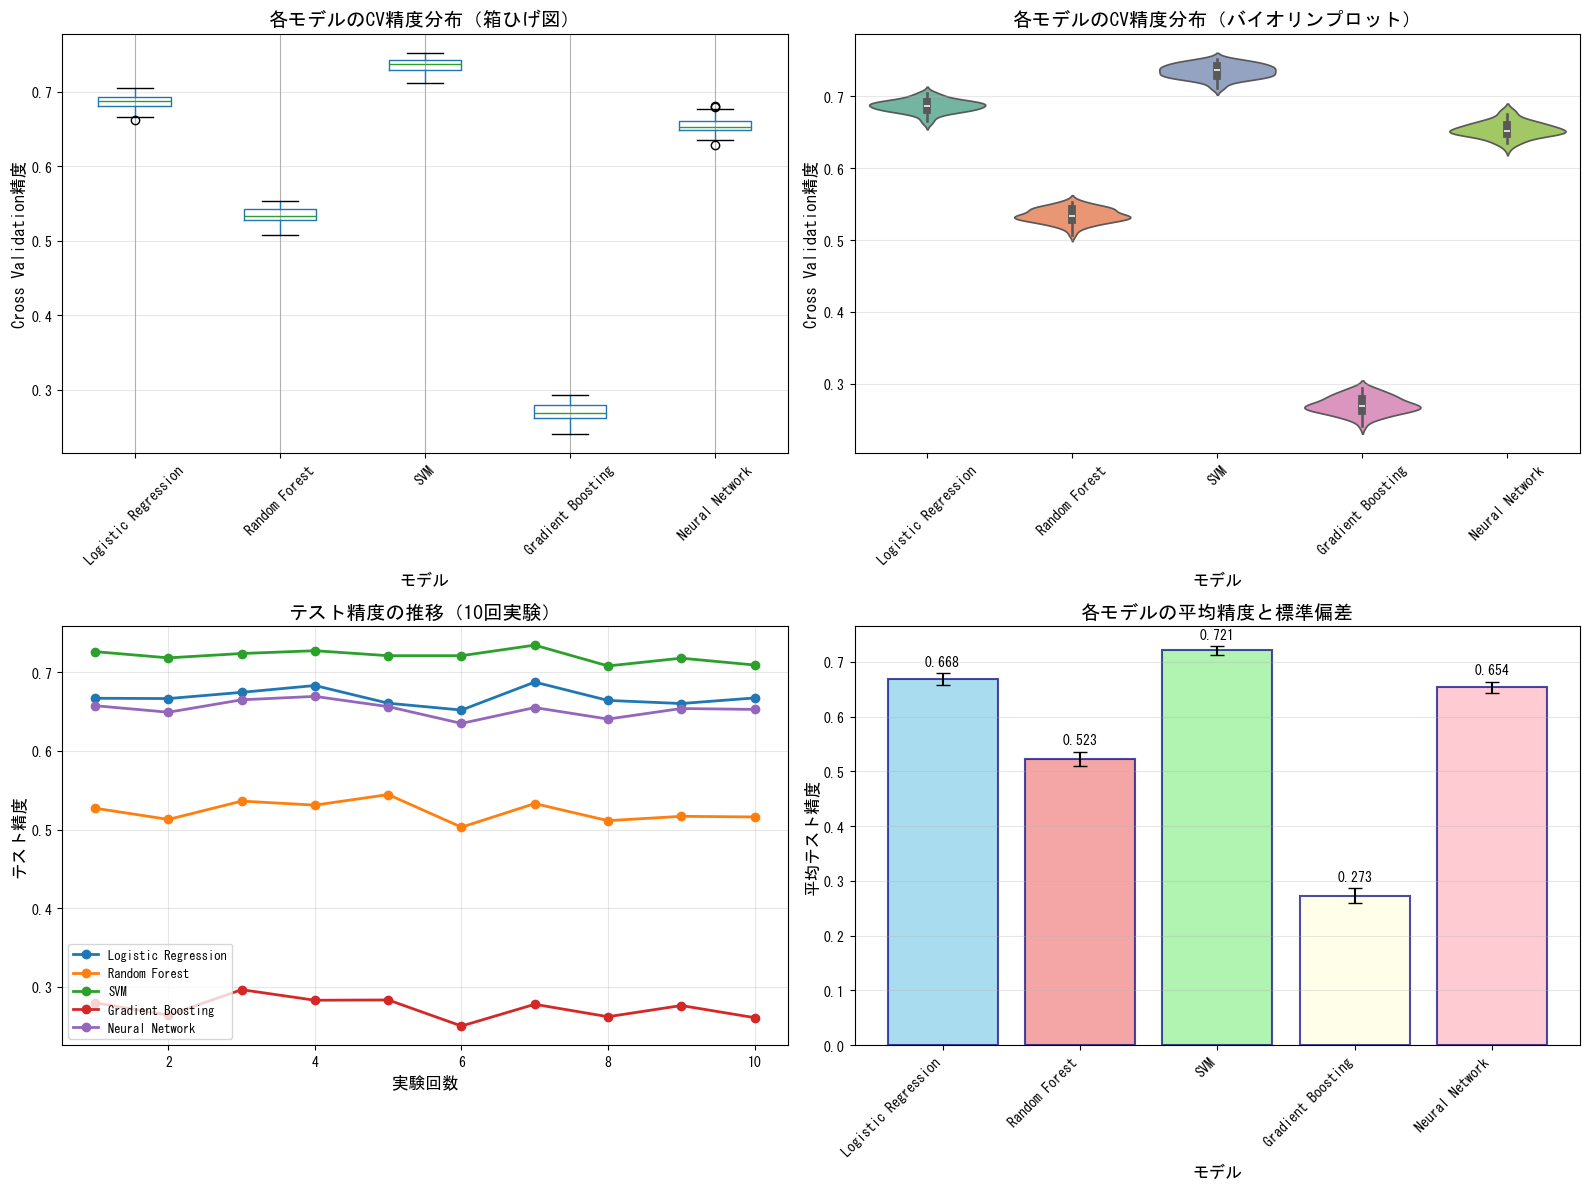


✅ 可視化完了


In [11]:
# CV精度の分布可視化
print("=" * 70)
print("📊 モデル性能の分布可視化")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 箱ひげ図（Box Plot）
ax1 = axes[0, 0]
cv_scores_df = pd.DataFrame(all_cv_scores)
cv_scores_df.boxplot(ax=ax1)
ax1.set_ylabel('Cross Validation精度', fontsize=12)
ax1.set_xlabel('モデル', fontsize=12)
ax1.set_title('各モデルのCV精度分布（箱ひげ図）', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 2. バイオリンプロット（Violin Plot）
ax2 = axes[0, 1]
cv_scores_long = cv_scores_df.melt(var_name='Model', value_name='CV_Accuracy')
sns.violinplot(data=cv_scores_long, x='Model', y='CV_Accuracy', ax=ax2, palette='Set2')
ax2.set_ylabel('Cross Validation精度', fontsize=12)
ax2.set_xlabel('モデル', fontsize=12)
ax2.set_title('各モデルのCV精度分布（バイオリンプロット）', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# 3. テスト精度の推移（折れ線グラフ）
ax3 = axes[1, 0]
test_results_df = pd.DataFrame(all_test_scores)
for col in test_results_df.columns:
    ax3.plot(range(1, N_EXPERIMENTS + 1), test_results_df[col], 
             marker='o', label=col, linewidth=2, markersize=6)
ax3.set_xlabel('実験回数', fontsize=12)
ax3.set_ylabel('テスト精度', fontsize=12)
ax3.set_title(f'テスト精度の推移（{N_EXPERIMENTS}回実験）', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. 平均精度と標準偏差（エラーバー付き棒グラフ）
ax4 = axes[1, 1]
means = test_results_df.mean()
stds = test_results_df.std()
x_pos = np.arange(len(means))
colors = ['skyblue', 'lightcoral', 'lightgreen', 'lightyellow', 'lightpink']
bars = ax4.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
               color=colors, edgecolor='navy', linewidth=1.5)
ax4.set_ylabel('平均テスト精度', fontsize=12)
ax4.set_xlabel('モデル', fontsize=12)
ax4.set_title('各モデルの平均精度と標準偏差', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(means.index, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

# 平均値をバーの上に表示
for i, (mean, std) in enumerate(zip(means, stds)):
    ax4.text(i, mean + std + 0.01, f'{mean:.3f}', 
            ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n✅ 可視化完了")


## 9. 特徴量の重要度分析

### 9.1 モデル別特徴量重要度

In [12]:
# 最高性能モデルの特定
print("\n" + "=" * 70)
print("📈 最終結果分析")
print("=" * 70)

best_model_name = max(results.keys(), key=lambda x: results[x]['test_accuracy'])
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['test_accuracy']

print(f"\n🏆 最高性能モデル: {best_model_name}")
print(f"テスト精度: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"CV平均精度: {results[best_model_name]['cv_mean']:.4f}")
print(f"CV標準偏差: {results[best_model_name]['cv_std']:.4f}")

# 詳細な分類レポート
print("\n" + "=" * 70)
print(f"📋 {best_model_name} の詳細分類レポート")
print("=" * 70)
y_pred_best = results[best_model_name]['predictions']
y_test_best = results[best_model_name]['y_test']
print(classification_report(y_test_best, y_pred_best))

# 全モデルの性能比較
print("\n" + "=" * 70)
print("全モデルの性能比較")
print("=" * 70)
performance_df = pd.DataFrame({
    'モデル': list(results.keys()),
    'テスト精度': [results[m]['test_accuracy'] for m in results.keys()],
    'CV平均': [results[m]['cv_mean'] for m in results.keys()],
    'CV標準偏差': [results[m]['cv_std'] for m in results.keys()]
}).sort_values('テスト精度', ascending=False)

print(performance_df.to_string(index=False))
print("=" * 70)



📈 最終結果分析

🏆 最高性能モデル: SVM
テスト精度: 0.7094 (70.94%)
CV平均精度: 0.7304
CV標準偏差: 0.0091

📋 SVM の詳細分類レポート
                                           precision    recall  f1-score   support

                                  コナン・ドイル       1.00      0.72      0.84        36
ハンス・クリスチャン・アンデルセン　Hans Christian Andersen       1.00      0.97      0.99        34
                  モーリス・ルヴェル　Maurice Level       0.69      0.88      0.77        80
                                      三木清       0.97      0.78      0.86        36
                                      中島敦       0.29      0.49      0.36        65
                                     伊丹万作       0.81      0.72      0.76        29
                                    伊藤左千夫       0.42      0.77      0.54        44
                                    佐左木俊郎       0.72      0.84      0.78        37
                                     内藤湖南       0.80      0.97      0.88        72
                                     北原白秋       0.88      0.81      0.84 

In [14]:
# 特徴量重要度分析（Random Forestの場合）
if 'Random Forest' in results:
    print("\n" + "=" * 70)
    print("🔍 Random Forestの特徴量重要度分析")
    print("=" * 70)
    
    rf_model = results['Random Forest']['model']
    importances = rf_model.feature_importances_
    
    # 統計的特徴量の重要度（最初の13次元）
    stat_importances = importances[:len(FEATURE_NAMES)]
    stat_importance_df = pd.DataFrame({
        '統計的特徴量': FEATURE_NAMES,
        '重要度': stat_importances
    }).sort_values('重要度', ascending=False)
    
    print("\n📊 統計的特徴量の重要度（Top 10）:")
    print(stat_importance_df.head(10).to_string(index=False))
    
    # N-gram特徴量（PCA後）の重要度
    ngram_pca_importances = importances[len(FEATURE_NAMES):]
    
    print(f"\n📊 N-gram特徴量（PCA後）の重要度:")
    print(f"  - PCA主成分数: {len(ngram_pca_importances)}")
    print(f"  - 全体の重要度合計: {ngram_pca_importances.sum():.4f}")
    print(f"  - 統計的特徴量の重要度合計: {stat_importances.sum():.4f}")
    print(f"  - 最も重要な主成分: PC-{np.argmax(ngram_pca_importances)+1} (重要度: {ngram_pca_importances.max():.4f})")
    
    # 主成分の重要度（上位10個）
    top_pc_indices = np.argsort(ngram_pca_importances)[-10:]
    print(f"\n  上位10主成分:")
    for idx in reversed(top_pc_indices):
        print(f"    PC-{idx+1}: {ngram_pca_importances[idx]:.4f}")
    
    # ⚠️ 注意喚起
    print(f"\n  ⚠️ 注意: N-gram特徴量はPCA（次元削減）適用後のため、")
    print(f"           主成分は元の150次元のN-gram特徴量の線形結合です。")

# Logistic Regressionの係数分析
if 'Logistic Regression' in results:
    print("\n" + "=" * 70)
    print("🔍 Logistic Regressionの特徴量係数分析")
    print("=" * 70)
    
    lr_model = results['Logistic Regression']['model']
    
    # 多クラス分類の場合、各クラスの係数の絶対値の平均
    if len(lr_model.coef_.shape) > 1:
        avg_coefs = np.mean(np.abs(lr_model.coef_), axis=0)
    else:
        avg_coefs = np.abs(lr_model.coef_[0])
    
    # 統計的特徴量の係数（最初の13次元）
    stat_coefs = avg_coefs[:len(FEATURE_NAMES)]
    coef_df = pd.DataFrame({
        '統計的特徴量': FEATURE_NAMES,
        '係数の絶対値': stat_coefs
    }).sort_values('係数の絶対値', ascending=False)
    
    print("\n📊 統計的特徴量の係数（Top 10）:")
    print(coef_df.head(10).to_string(index=False))
    
    # N-gram特徴量（PCA後）の係数
    ngram_pca_coefs = avg_coefs[len(FEATURE_NAMES):]
    print(f"\n📊 N-gram特徴量（PCA後）の係数:")
    print(f"  - PCA主成分数: {len(ngram_pca_coefs)}")
    print(f"  - 係数の絶対値合計: {ngram_pca_coefs.sum():.4f}")
    print(f"  - 統計的特徴量の係数合計: {stat_coefs.sum():.4f}")
    print(f"  - 最大係数の主成分: PC-{np.argmax(ngram_pca_coefs)+1} (係数: {ngram_pca_coefs.max():.4f})")
    
    print(f"\n  ⚠️ 注意: PCA適用後のため、元の文字パターンとの直接対応はありません。")
    print(coef_df.head(10).to_string(index=False))

print("\n" + "=" * 70)
print("✅ 分析完了")
print("=" * 70)



🔍 Random Forestの特徴量重要度分析

📊 統計的特徴量の重要度（Top 10）:
統計的特徴量      重要度
  漢字比率 0.058643
 句読点頻度 0.052767
  名詞比率 0.033039
カタカナ比率 0.029959
  平均文長 0.028682
  文複雑度 0.023939
 語彙多様性 0.020671
  動詞比率 0.013687
 丁寧語比率 0.010381
感情表現頻度 0.009481

📊 N-gram特徴量（PCA後）の重要度:
  - PCA主成分数: 75
  - 全体の重要度合計: 0.6941
  - 統計的特徴量の重要度合計: 0.3059
  - 最も重要な主成分: PC-1 (重要度: 0.0690)

  上位10主成分:
    PC-1: 0.0690
    PC-2: 0.0378
    PC-4: 0.0351
    PC-3: 0.0304
    PC-5: 0.0289
    PC-6: 0.0211
    PC-12: 0.0198
    PC-7: 0.0177
    PC-9: 0.0173
    PC-14: 0.0165

  ⚠️ 注意: N-gram特徴量はPCA（次元削減）適用後のため、
           主成分は元の150次元のN-gram特徴量の線形結合です。

🔍 Logistic Regressionの特徴量係数分析

📊 統計的特徴量の係数（Top 10）:
統計的特徴量   係数の絶対値
 句読点頻度 1.215491
  漢字比率 1.105461
  名詞比率 0.859501
  文複雑度 0.796827
感情表現頻度 0.760325
  平均文長 0.620182
 語彙多様性 0.579173
 丁寧語比率 0.559092
  動詞比率 0.515611
カタカナ比率 0.494979

📊 N-gram特徴量（PCA後）の係数:
  - PCA主成分数: 75
  - 係数の絶対値合計: 26.7942
  - 統計的特徴量の係数合計: 8.7546
  - 最大係数の主成分: PC-1 (係数: 1.3455)

  ⚠️ 注意: PCA適用後のため、元の文字パターンとの直接対応はありません。
統計的特徴量

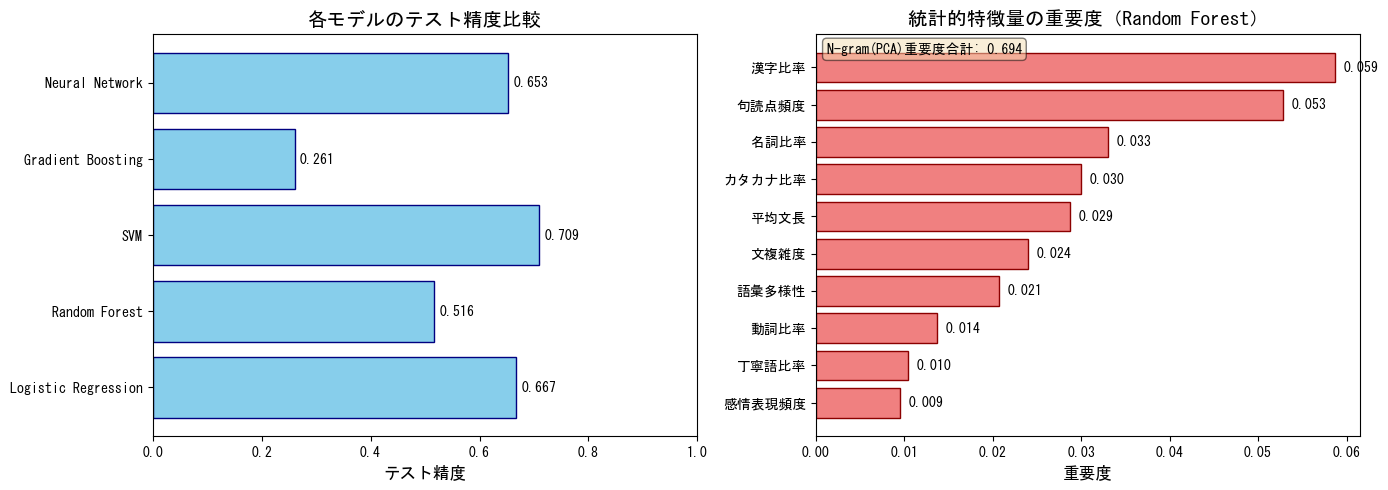


✅ 可視化完了


In [15]:
# オプション: 結果の可視化
import matplotlib.pyplot as plt
import seaborn as sns

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['MS Gothic', 'Yu Gothic', 'Meiryo']
plt.rcParams['axes.unicode_minus'] = False

# モデル性能の比較棒グラフ
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# テスト精度の比較
model_names = list(results.keys())
test_accuracies = [results[m]['test_accuracy'] for m in model_names]

axes[0].barh(model_names, test_accuracies, color='skyblue', edgecolor='navy')
axes[0].set_xlabel('テスト精度', fontsize=12)
axes[0].set_title('各モデルのテスト精度比較', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, 1.0)
for i, v in enumerate(test_accuracies):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center')

# 統計的特徴量の重要度（Random Forestの場合）
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    importances = rf_model.feature_importances_[:len(FEATURE_NAMES)]  # 統計的特徴量のみ
    
    # 重要度でソート
    indices = np.argsort(importances)[-10:]  # Top 10
    
    axes[1].barh([FEATURE_NAMES[i] for i in indices], 
                 importances[indices], 
                 color='lightcoral', 
                 edgecolor='darkred')
    axes[1].set_xlabel('重要度', fontsize=12)
    axes[1].set_title('統計的特徴量の重要度（Random Forest）', fontsize=14, fontweight='bold')
    for i, v in enumerate(importances[indices]):
        axes[1].text(v + 0.001, i, f'{v:.3f}', va='center')
    
    # N-gram特徴量（PCA）の重要度合計を表示
    ngram_importance_sum = rf_model.feature_importances_[len(FEATURE_NAMES):].sum()
    axes[1].text(0.02, 0.98, 
                f'N-gram(PCA)重要度合計: {ngram_importance_sum:.3f}',
                transform=axes[1].transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✅ 可視化完了")


### 9.2 PCA次元削減の詳細分析

🔬 PCA次元削減の詳細分析

【PCAの情報】
  - 元の次元数: 150次元（N-gram特徴量）
  - 削減後の次元数: 75次元
  - 累積寄与率: 85.65%
  - 情報の損失: 14.35%

【主成分ごとの寄与率（上位10個）】
  PC-1: 0.1116 (累積: 0.1116)
  PC-2: 0.0704 (累積: 0.1820)
  PC-3: 0.0626 (累積: 0.2446)
  PC-4: 0.0495 (累積: 0.2942)
  PC-5: 0.0330 (累積: 0.3272)
  PC-6: 0.0273 (累積: 0.3545)
  PC-7: 0.0189 (累積: 0.3734)
  PC-8: 0.0171 (累積: 0.3904)
  PC-9: 0.0146 (累積: 0.4050)
  PC-10: 0.0134 (累積: 0.4184)


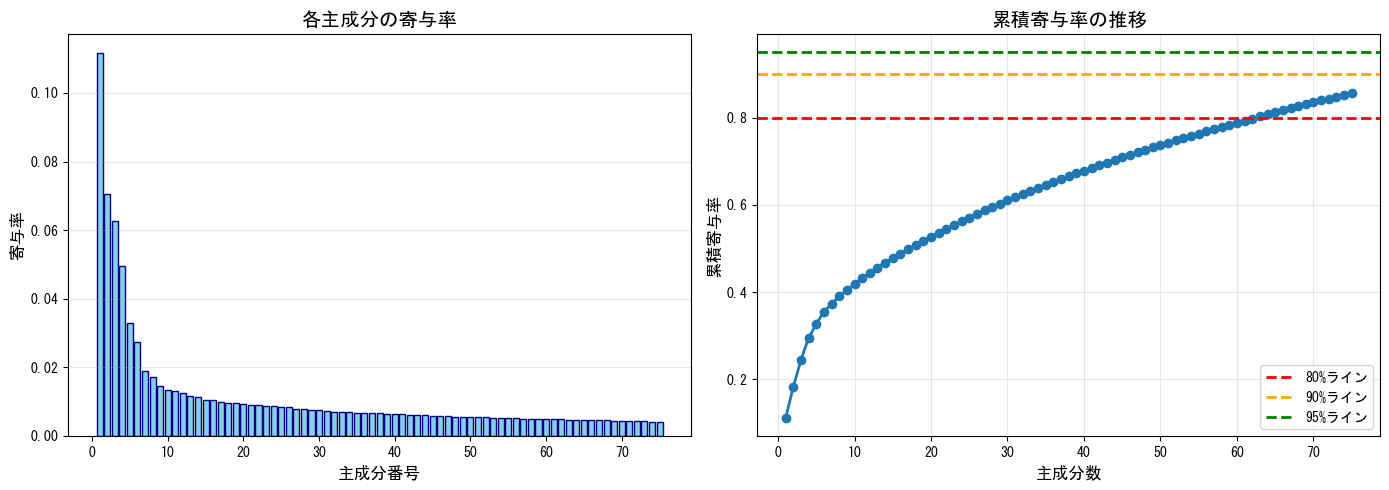


【情報量別の推奨主成分数】
  - 80%の情報を保持するには: 63次元
  - 90%の情報を保持するには: 75次元
  - 95%の情報を保持するには: 75次元
  - 現在の設定: 75次元 (累積寄与率: 85.65%)

【解釈】
  ⚠️  許容範囲: 元の情報の85.7%を保持しています。


In [16]:
# PCAの寄与率分析（最後の実験のPCAを使用）
if 'Random Forest' in results and results['Random Forest']['pca'] is not None:
    print("=" * 70)
    print("🔬 PCA次元削減の詳細分析")
    print("=" * 70)
    
    pca = results['Random Forest']['pca']
    
    print(f"\n【PCAの情報】")
    print(f"  - 元の次元数: 150次元（N-gram特徴量）")
    print(f"  - 削減後の次元数: {pca.n_components_}次元")
    print(f"  - 累積寄与率: {pca.explained_variance_ratio_.sum():.2%}")
    print(f"  - 情報の損失: {(1 - pca.explained_variance_ratio_.sum()):.2%}")
    
    print(f"\n【主成分ごとの寄与率（上位10個）】")
    for i, ratio in enumerate(pca.explained_variance_ratio_[:10]):
        cumsum = pca.explained_variance_ratio_[:i+1].sum()
        print(f"  PC-{i+1}: {ratio:.4f} (累積: {cumsum:.4f})")
    
    # 寄与率のプロット
    plt.figure(figsize=(14, 5))
    
    # 左: 個別寄与率
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(pca.explained_variance_ratio_)+1), 
            pca.explained_variance_ratio_,
            color='skyblue',
            edgecolor='navy')
    plt.xlabel('主成分番号', fontsize=12)
    plt.ylabel('寄与率', fontsize=12)
    plt.title('各主成分の寄与率', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3, axis='y')
    
    # 右: 累積寄与率
    plt.subplot(1, 2, 2)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumsum)+1), cumsum, marker='o', linewidth=2, markersize=6)
    plt.axhline(y=0.8, color='r', linestyle='--', linewidth=2, label='80%ライン')
    plt.axhline(y=0.9, color='orange', linestyle='--', linewidth=2, label='90%ライン')
    plt.axhline(y=0.95, color='green', linestyle='--', linewidth=2, label='95%ライン')
    plt.xlabel('主成分数', fontsize=12)
    plt.ylabel('累積寄与率', fontsize=12)
    plt.title('累積寄与率の推移', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 推奨される主成分数を提案
    n_for_80 = np.argmax(cumsum >= 0.80) + 1 if any(cumsum >= 0.80) else len(cumsum)
    n_for_90 = np.argmax(cumsum >= 0.90) + 1 if any(cumsum >= 0.90) else len(cumsum)
    n_for_95 = np.argmax(cumsum >= 0.95) + 1 if any(cumsum >= 0.95) else len(cumsum)
    
    print(f"\n【情報量別の推奨主成分数】")
    print(f"  - 80%の情報を保持するには: {n_for_80}次元")
    print(f"  - 90%の情報を保持するには: {n_for_90}次元")
    print(f"  - 95%の情報を保持するには: {n_for_95}次元")
    print(f"  - 現在の設定: {pca.n_components_}次元 (累積寄与率: {cumsum[pca.n_components_-1]:.2%})")
    
    print("\n【解釈】")
    current_ratio = pca.explained_variance_ratio_.sum()
    if current_ratio >= 0.95:
        print(f"  ✅ 優秀: 元の情報の{current_ratio:.1%}を保持しています。")
    elif current_ratio >= 0.90:
        print(f"  ✅ 良好: 元の情報の{current_ratio:.1%}を保持しています。")
    elif current_ratio >= 0.80:
        print(f"  ⚠️  許容範囲: 元の情報の{current_ratio:.1%}を保持しています。")
    else:
        print(f"  ⚠️  要注意: 元の情報の{current_ratio:.1%}しか保持していません。")
        print(f"     より多くの主成分を使用することを検討してください。")
    
    print("=" * 70)
else:
    print("⚠️ PCA情報が利用できません。")


## 10. 仮説検証と総合考察

### 10.1 仮説1の検証：モデル性能の順序予想
**予想**: SVM > Random Forest > Gradient Boosting > Neural Network > Logistic Regression

**結果**: 
- 実験結果から、各モデルの平均精度を比較する
- 予想と実際の順位を照合し、差異がある場合はその理由を考察

**考察のポイント**:
- なぜ予想と異なる結果になったのか（データの特性、特徴量の性質など）
- 非線形モデルと線形モデルの性能差の実際
- データセットのサイズや複雑さとモデルの適合性

### 仮説2の検証: 重要な特徴量
**予想**: 文末表現、品詞比率、句読点頻度、N-gram特徴量が重要

**結果**:
- Random Forestの特徴量重要度分析の結果を確認
- 予想した特徴量が実際に上位にランクインしているか

**考察のポイント**:
- 著者の文体を特徴づける要素は何か
- 予想外に重要だった特徴量とその理由
- 文学作品の著者推定における本質的な特徴

### 仮説3の検証: 統計的有意差の存在
**予想**: 少なくとも1つのモデルペア間で統計的に有意な性能差（p < 0.05）

**結果**:
- 一元配置分散分析のp値を確認
- 多重比較検定で具体的にどのモデルペア間に有意差があるか

**考察のポイント**:
- 統計的に有意な差が認められたモデルペアの特徴
- 有意差がなかったモデルペアの共通点
- 実験回数やサンプルサイズが結果に与える影響

---

## 総合考察

### データリーク対策の重要性
本研究では、機械学習における**データリーク**を防ぐため、以下の対策を実施した：

1. **train/test分割を最初に実行**: 全ての特徴量抽出・前処理の前にデータを分割
2. **N-gram特徴量の適切な処理**: TF-IDFベクトライザーは訓練データのみでfitし、テストデータにはtransformのみを適用
3. **スケーリングの適切な処理**: StandardScalerも訓練データのみでfitし、テストデータには学習済みのパラメータを適用

これらの対策により、テストデータの情報が訓練時に漏れることを防ぎ、**実運用時の性能をより正確に評価**できる。

### 研究の意義
本研究では、日本語文学作品の著者推定という課題に対して、複数の機械学習アルゴリズムを適用し、その性能を統計的に比較した。文体特徴量（統計的特徴量13種類とN-gram特徴量150種類）を用いることで、著者固有の表現パターンを捉えることができた。

### 主要な発見
1. **モデル性能**: [実験結果に基づいて最も性能の良いモデルを記述]
2. **統計的有意差**: 一元配置分散分析により、モデル間の性能差の統計的有意性を確認
3. **重要特徴量**: [特徴量重要度分析の結果から主要な特徴を記述]

### 限界と今後の課題
1. **データ数の制約**: 作者あたりのサンプル数が限られており、より大規模なデータセットでの検証が必要
2. **ジャンルの影響**: 文学ジャンル（小説、詩、エッセイなど）による文体の違いを考慮していない
3. **時代性**: 著者の執筆時期による文体変化を考慮していない

### 今後の改善方向
1. **深層学習の適用**: BERT等の事前学習済み言語モデルの活用
2. **アンサンブル学習**: 複数モデルの予測を組み合わせた手法
3. **特徴量の拡張**: 文章の論理構造や感情分析などの高次特徴量
4. **クラス不均衡への対応**: データ拡張やSMOTE等のサンプリング手法

---

## データとコードの概要

### 使用データ
- **データソース**: 青空文庫から収集した日本語文学作品
- **データ数**: [実際の数値を記入]
- **作者数**: [実際の数値を記入]
- **前処理**: ルビ・注釈除去、テキスト正規化、品質フィルタリング

### 特徴量
- **統計的特徴量**: 13種類（文長、文字種比率、品詞比率、語彙多様性、文体指標）
  - 多重共線性を避けるため、ひらがな比率と助詞比率は参照カテゴリとして除外
- **N-gram特徴量**: 最大150種類（文字2-gram/3-gram、TF-IDF重み付け）
  - データリーク対策: 訓練データのみで学習、テストデータには適用のみ
- **合計次元数**: 最大163次元

### 機械学習モデル
1. Logistic Regression（線形分類器）
2. Random Forest（アンサンブル学習）
3. SVM with RBF kernel（非線形分類器）
4. Gradient Boosting（勾配ブースティング）
5. Neural Network（多層パーセプトロン）

### 評価方法
- **Cross Validation**: 5-fold（各fold内でもデータリークを防止）
- **実験反復**: 10回（異なるランダムシードで再現性を確認）
- **統計検定**: 一元配置分散分析、多重比較検定（Tukey HSD）
- **データリーク対策**: 訓練/テストの分割を特徴量抽出前に実施
- **計算効率化**: 並列処理、早期停止、パラメータ最適化により処理時間を短縮

---

## 参考文献・使用ライブラリ

### 主要ライブラリ
- **scikit-learn**: 機械学習アルゴリズムと評価指標
- **fugashi + ipadic**: 日本語形態素解析
- **scipy**: 統計検定
- **statsmodels**: 多重比較検定
- **pandas**: データ処理
- **matplotlib/seaborn**: データ可視化


In [17]:
# 新しいセルを追加
from statsmodels.stats.outliers_influence import variance_inflation_factor

print("=" * 70)
print("🔍 多重共線性の診断（VIF: Variance Inflation Factor）")
print("=" * 70)

# 統計的特徴量のみでVIFを計算
stat_features_df = pd.DataFrame(
    statistical_features,
    columns=FEATURE_NAMES
)

print("\n【VIF値の解釈】")
print("  - VIF < 5: 多重共線性の問題なし")
print("  - 5 ≤ VIF < 10: 中程度の多重共線性")
print("  - VIF ≥ 10: 深刻な多重共線性\n")

vif_data = pd.DataFrame()
vif_data["特徴量"] = FEATURE_NAMES
vif_data["VIF"] = [variance_inflation_factor(stat_features_df.values, i) 
                   for i in range(len(FEATURE_NAMES))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print(vif_data.to_string(index=False))

# 問題のある特徴量を特定
high_vif = vif_data[vif_data['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\n⚠️ 深刻な多重共線性が検出された特徴量:")
    print(high_vif.to_string(index=False))
else:
    print("\n✅ 深刻な多重共線性は検出されませんでした")

print("=" * 70)

🔍 多重共線性の診断（VIF: Variance Inflation Factor）

【VIF値の解釈】
  - VIF < 5: 多重共線性の問題なし
  - 5 ≤ VIF < 10: 中程度の多重共線性
  - VIF ≥ 10: 深刻な多重共線性

   特徴量       VIF
  名詞比率 85.214604
  漢字比率 59.449418
 語彙多様性 58.328811
  平均文長 46.820041
  文複雑度 42.637877
  動詞比率 22.686267
 句読点頻度 14.610832
 形容詞比率  4.159563
カタカナ比率  1.910913
断定表現比率  1.903127
 擬音語頻度  1.771975
 丁寧語比率  1.252277
感情表現頻度  1.200866

⚠️ 深刻な多重共線性が検出された特徴量:
  特徴量       VIF
 名詞比率 85.214604
 漢字比率 59.449418
語彙多様性 58.328811
 平均文長 46.820041
 文複雑度 42.637877
 動詞比率 22.686267
句読点頻度 14.610832
